# Download unified dataset

In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,scanpy,requests,json -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Thu Jul 30 2020 

CPython 3.7.6
IPython 7.15.0

pandas 1.0.4
numpy 1.18.5
scanpy 1.5.1
requests 2.23.0
json 2.0.9

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : df05e067909dc50d183de4d499eabecef3567de2
Git repo   : git@github.com:fvalle1/cancers
Git branch : develop
watermark 2.0.2


In [2]:
# import libraries
import pandas as pd
import numpy as np
import scanpy as sc
import requests
import json
import os, sys

## Download data
Download data from [https://doi.org/10.6084/m9.figshare.5330593](https://doi.org/10.6084/m9.figshare.5330593) and [https://figshare.com/articles/Data_record_3/5330593](https://figshare.com/articles/Data_record_3/5330593) and set working_dir appropriately

In [3]:
#path/to/files/downloaded/
working_dir = "../unified_lung/"
os.chdir(working_dir)

In [4]:
files = filter(lambda f: "fpkm" in f, os.listdir("data"))

Download GTEx metadata from[http://gtexportal.org](http://gtexportal.org)

In [5]:
df_gtex=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)

Download TCGA metadata using gdc API

In [6]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        }
        
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": "primary_site,disease_type,submitter_id,project.project_id",
    "format": "TSV",
    "size": "10000000"
    }
response = requests.get("https://api.gdc.cancer.gov/cases", headers = {"Content-Type": "application/json"}, params = params)
with open("files.txt","w") as file:
    file.write(response.content.decode("utf-8"))
df_tcga = pd.read_csv("files.txt", sep='\t').set_index("submitter_id")

Create an empty DataFrame to fulfill with unified dataset

In [7]:
df=pd.read_csv("mainTable.csv", index_col=0)

In [ ]:
df=pd.DataFrame()

In [ ]:
for file in files:
    df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id',1).transpose(), sort=True)
df = df.transpose()
df = df.dropna(how='any', axis=0) # drop genes not always determined

Prepare a metadata file

In [9]:
df_files = pd.DataFrame(index=df.columns)

We define useful function to discriminate samples coming from GTEx and TCGA

In [10]:
def get_site(file):
    '''
    Returns GTEX or TCGA primary site
    '''
    if ("df_gtex" not in globals().keys()) or ("df_tcga" not in globals().keys()):
        raise NotImplementedError("Please define datasets with gtex and tcga metadata")
    if 'GTEX' in file:
        return df_gtex.at[file, 'SMTS']
    if 'TCGA' in file:
        return df_tcga.at[file[:12],'primary_site']

def get_source(file):
    if 'GTEX' in file:
        return 'gtex'
    if 'TCGA' in file:
        return 'tcga'

#https://www.researchgate.net/post/How_can_I_get_the_normal_sample_of_TCGA_data
def get_status(file):
    if 'GTEX' in file:
        return 'healthy'
    if 'TCGA' in file:
        if (file[13:15]=="11") or (file[13:15]=="10"):
            return 'healthy'
        else:
            return "tumor"

In [11]:
df_files.insert(0, 'primary_site', [get_site(file) for file in df.columns])
df_files.insert(1, 'dataset', [get_source(file) for file in df.columns])
df_files.insert(1, 'status', [get_status(file) for file in df.columns])
df_files.groupby(["dataset","status"]).count()

primary_site
dataset status               
gtex    healthy           313
tcga    healthy           110
        tumor             992

Save metadata file

In [12]:
df_files.to_csv("../unified_lung/files_unified.dat", index=True, header=True)

## Split / shuffle and select

In [13]:
df_files = pd.read_csv("../unified_lung/files_unified.dat", index_col=0)

Unify names in different datasets

In [14]:
df_files.replace('Uterus, NOS', 'Uterus', inplace=True)
df_files.replace('Bronchus and lung', 'Lung', inplace=True)
df_files.replace('Liver and intrahepatic bile ducts', 'Liver', inplace=True)
df_files.replace('Prostate gland', 'Prostate', inplace=True)
df_files.replace('Thyroid gland', 'Thyroid', inplace=True)
df_files.replace('Base of Tongue', 'Salivary Gland', inplace=True)
df_files.replace('Bones, joints and articular cartilage of other and unspecified sites', 'Salivary Gland', inplace=True)
df_files.replace('Floor of mouth', 'Salivary Gland', inplace=True)
df_files.replace('Gum', 'Salivary Gland', inplace=True)
df_files.replace('Hypopharynx', 'Salivary Gland', inplace=True)
df_files.replace('Larynx', 'Salivary Gland', inplace=True)
df_files.replace('Lip', 'Salivary Gland', inplace=True)
df_files.replace('Oropharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and unspecified parts of mouth', 'Salivary Gland', inplace=True)
df_files["tissue_hd"]=df_files["primary_site"]+"_"+df_files["dataset"]
df_files['primary_site'].unique()

array(['Lung'], dtype=object)

In [15]:
samples = df_files[df_files["primary_site"]=="Lung"]

In [17]:
df[df.columns[df.columns.isin(samples.index)]].to_csv("../unified_lung/mainTable_all.csv", index=True, header=True)

In [18]:
df_files.to_csv("../unified_lung/files_unified.dat", index=True, header=True)

In [19]:
df_merged_file = pd.read_csv("../unified_lung/files_unified.dat", index_col=0)
df_merged = df_merged_file[df_merged_file["primary_site"]=="Lung"]
df_query = pd.read_csv("../unified_lung/files_tcga.dat")
df_query = df_query[df_query["cases.0.project.project_id"].isin(["TCGA-LUAD","TCGA-LUSC"])]
df_query.set_index("cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id", inplace=True)
df_discordant = pd.read_csv("https://raw.githubusercontent.com/ELELAB/LUAD_LUSC_TCGA_comparison/master/6-recount/LUSC/discordant_samples.txt", header=None)

Define *Discordant_Lusc* and set labels

In [20]:
df_merged["Subtype"]=df_merged["status"]
df_merged["Type"]=df_merged["status"]
df_tmp = df_query
df_tmp=df_tmp[df_tmp.index.isin(df_merged.index)]
df_tmp["cancer.type"]="unknown"
df_tmp["Subtype_Selected"]="unknown"
for sample in df_query.index:
    df_merged.at[sample, "status"]=get_status(sample)
    df_merged.at[sample, "dataset"]=get_source(sample)
    df_merged.at[sample, "primary_site"]=get_site(sample)
    df_merged.at[sample, "Subtype"]=df_merged.at[sample,"dataset"]+"_"+df_merged.at[sample,"status"]
for sample in df_merged.index:
    if sample in df_query.index.values.ravel():
        if df_merged.at[sample,"status"]=="tumor": #they should not be TCGA healthy
            df_merged.at[sample,"Type"]=df_query.at[sample,"cases.0.project.project_id"][-4:]
    if sample in df_discordant.values.ravel():
        df_merged.at[sample,"Type"]="Discordant_LUSC"
print("Done")
df_merged = df_merged.transpose().append(df_query.transpose(), ignore_index=False).transpose()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Done


In [21]:
df_merged.at["TCGA-37-4133-01A-01R-1100-07-1","Type"]="LUSC"
df_merged.at["TCGA-55-1595-01A-01R-0946-07","Type"]="LUSC"
df_merged.at["TCGA-38-4625-01A-01R-1206-07-1","Type"]="LUAD"
df_merged.at["TCGA-44-2665-01A-01R-A278-07","Type"]="LUAD"
df_merged.at["TCGA-37-4132-01A-01R-1100-07-1","Type"]="LUSC"
df_merged.at["TCGA-55-6969-01A-11R-1949-07","Type"]="LUAD"
df_merged.at["TCGA-62-A46U-01A-11R-A24H-07","Type"]="LUAD"
df_merged.at["TCGA-44-4112-01A-01R-A278-07","Type"]="LUAD"

In [22]:
df_merged["Type"].unique()

array(['LUAD', 'LUSC', 'healthy', 'Discordant_LUSC'], dtype=object)

In [23]:
df_merged.fillna(np.nan).to_csv("../unified_lung/files.dat")

# Use scanpy to filter HVG

In [24]:
adata = sc.AnnData(df[samples.index].transpose(), obs=samples)
adata_log = sc.pp.log1p(adata, copy=True)

In [25]:
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50)

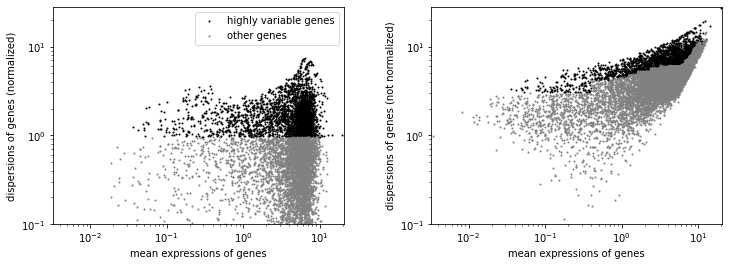

In [26]:
sc.pl.highly_variable_genes(adata_log, log=True, save='hvg.pdf')

In [27]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

In [28]:
df.reindex(index=hvg, columns=samples).to_csv("../unified_lung/mainTable.csv", index=True, header=True)

# Run hierarchical Stochastic Block Model

In [ ]:
from sbmtm import sbmtm

In [ ]:
model = sbmtm()

In [ ]:
model.make_graph_from_BoW_df(df.loc[hvg, samples])

In [ ]:
model.save_graph("graph.xml.gz")